## Problem

Meanwhile Dr. Jim, the ecologist was sitting silent. You and your friends approached him to know what he was thinking about deeply. He said he was wondering about the patterns of flight of the extinct dinosaur (the bone they had found earlier). He smiles and asks you if you can model a flight simulation given certain well-thought constraints about the movements of the creatures.

Dr. Jim tells that the individual creatures ("let's call them Aveosaurs") are inverted triangular 2D creatures (for the 2D simulation). Each Aveosaur has an internal state (position, velocity, mass) and an external state (knowledge about flock members within a certain radius in their neighborhood). The Aveosaurs have 3 main behaviors (forces that act on it):

- Separation: Each Aveosaur considers its distance to nearby flock mates and applies a repulsive force in the opposite direction to the nearest neighbor, scaled by the inverse of the distance.
- Cohesion: Each Aveosaur moves in the direction of the average position of its neighbors.
- Alignment: Each Aveosaur aligns its direction to the average direction of its nearest neighbors within a provided radius.

At each time step, each Aveosaur follows the above three rules, calculates it position and moves to it. Run a visual simulation and if possible save the output sequence as a series of images/video file so that Dr. Jim can analyse the group behavior patterns.

### Values

- Assume the sky is 1200m X 800m
- Each time step is 1 second (though this doesn't matter)
- Mass of Aveosaurs - should be randomly selected for each individual (varies from 50 to 250 kgs)
- Initiate positions randomly
- Initiate velocities (as 2D vectors) with magnitudes randomly selected between -9 to 9 mps
- radius of knowledge - 80m
- begin with 100 creatures
- leave out the constants (for force laws) as settable
- Plot it in such a way that we can see the direction of the Aveosaur
- Assume periodic boundary conditions. Basically, birds which fly out of the left fly back in from the right, etc.

## Solution

This is a simple implementation using OOPS.  
Some of the finer details have been left out due to limited time on the end of the author (yeah, sorry 😢 ).  
The explanation is pretty simple but a tad bit too long, so it has been omitted for the time being. I will post it up once I'm done with my Thesis.

These are the things that are knowingly left out for now:
- The triangles don't point towards the direction the Aveosaur is headed
- Actual force laws have been modified a bit to make for a simpler execution

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Simulation constants
radius_of_knowledge = 80
width = 1200
height = 800

# Force constants - currently not in use
cohesion_coef = 1.0
separation_coef = 1.0
alignment_coef = 1.0

In [2]:
# Class to handle vector operations - all positions w.r.t. origin (cartesian coordinates)
class Vector2:
    def __init__(self, x, y):
        self.pos = np.array([float(x), float(y)])
        
    # Add a vector
    def add(self, vec):
        self.pos += vec.pos
    
    # Scalar multiplication
    def mult(self, scalar):
        self.pos *= scalar
    
    # Scalar division
    def div(self, scalar):
        if scalar != 0:
            self.pos /= float(scalar)
        else:
            raise Exception("Division by zero not supported")
          
    # Magnitude of the vector
    def mag(self):
        return sqrt((self.pos[0] ** 2) + (self.pos[1] ** 2))
    
    # Normalize the vector
    def normalize(self):
        mag = self.mag()
        if mag != 0.0:
            self.pos /= mag
    
    # Distance between 2 vectors
    @staticmethod
    def dist(vec1, vec2):
        distance = sqrt((vec1.pos[0] - vec2.pos[1]) ** 2 + (vec1.pos[1] - vec2.pos[0]) ** 2)
        return distance
        
    # Difference between 2 vectors
    @staticmethod
    def sub(vec1, vec2):
        result = vec1.pos - vec2.pos
        result = Vector2(result[0], result[1])
        return result
    
    # Average location of a group of vectors
    @staticmethod
    def avg_pos(vectors):
        x = 0.0
        y = 0.0
        count = 0.0
        for vec in vectors:
            x += vec.pos[0]
            y += vec.pos[1]
            count += 1
        if count != 0.0:
            res = Vector2(x / count, y / count)
        else:
            res = False
        return res

In [3]:
class Aveosaur:
    def __init__(self):
        self.mass = np.random.uniform(50, 250)
        self.velocity = Vector2(np.random.uniform(-19/sqrt(2), 19/sqrt(2)), np.random.uniform(-19/sqrt(2), 19/sqrt(2)))
        self.position = Vector2(np.random.uniform(0, width), np.random.uniform(0, height))
        self.acceleration = Vector2(0.0, 0.0)
        self.max_speed = 10
        self.radius = 5
        
    # Returns position of the aveosaur
    def get_pos(self):
        return self.position
    
    # Function for calculating force of alignment
    def alignment(self, aveosaurs):
        sum = Vector2(0.0, 0.0)
        count = 0
        for aveosaur in aveosaurs:
            distance = Vector2.dist(self.position, aveosaur.position)
            if (distance > 0) and (distance < radius_of_knowledge):
                sum.add(aveosaur.velocity)
                count += 1
        if count > 0:
            sum.div(count)
            sum.normalize()
            sum.mult(self.max_speed)
            force = Vector2.sub(sum, self.velocity)
            self.apply_force(force)
    
    # Function for calculating force of cohesion
    def cohesion(self, aveosaurs):
        neighbours = []
        for aveosaur in aveosaurs:
            distance = Vector2.dist(self.position, aveosaur.position)
            if (distance > 0) and (distance < radius_of_knowledge):
                neighbours.append(aveosaur.position)
        target = Vector2.avg_pos(neighbours)
        if target:
            self.seek(target)
        
    # Function for calculating force of separation
    def separation(self, aveosaurs):
        desired_separation = self.radius * 100
        sum = Vector2(0.0, 0.0)
        count = 0
        for aveosaur in aveosaurs:
            distance = Vector2.dist(self.position, aveosaur.position)
            if (distance > 0) and (distance < desired_separation):
                diff = Vector2.sub(self.position, aveosaur.position)
                diff.normalize()
                diff.div(distance)
                sum.add(diff)
                count += 1
        if count > 0:
            sum.div(count)
            sum.normalize()
            sum.mult(self.max_speed)
            force = Vector2.sub(sum, self.velocity)
            self.apply_force(force)
         
    # Function for seeking behaviour
    def seek(self, target):
        desired = Vector2.sub(target, self.position)
        desired.normalize()
        desired.mult(self.max_speed)
        force = Vector2.sub(desired, self.velocity)
        self.apply_force(force)
        
    # Boundary conditions
    def edge(self):
        if self.position.pos[0] < 0:
            self.position.pos[0] = width
        elif self.position.pos[0] > width:
            self.position.pos[0] = 0
        if self.position.pos[1] < 0:
            self.position.pos[1] = height
        elif self.position.pos[1] > height:
            self.position.pos[1] = 0
        
    # Updates the position of aveosaur
    def update(self):
        self.velocity.add(self.acceleration)
        self.position.add(self.velocity)
        self.acceleration.mult(0)
       
    # Applies said force to aveosaur
    def apply_force(self, force):
        force.div(float(self.mass))
        self.acceleration.add(force)

<IPython.core.display.Javascript object>


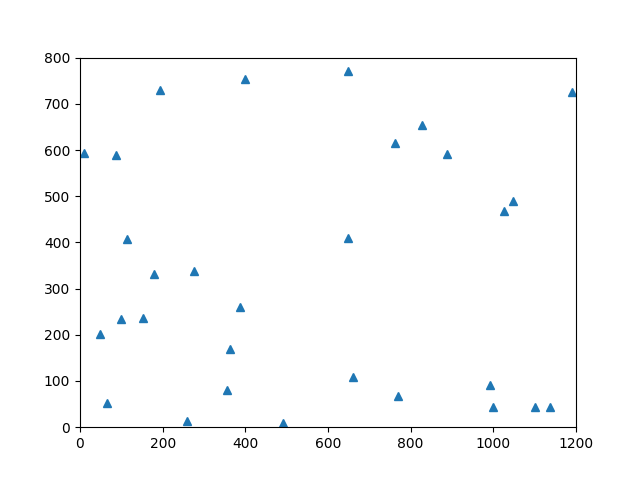

In [4]:
%matplotlib notebook

# Initialize creatures
aveosaurs = [Aveosaur() for i in range(30)]

# Initialize plot
fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], '^')

# Init method for animation (just the axes)
def init():
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    return ln,

# Update method for plotting aveosaurs
def update(frame):
    xdata = []
    ydata = []
    for aveosaur in aveosaurs:
        aveosaur.alignment(aveosaurs)
        aveosaur.cohesion(aveosaurs)
        aveosaur.separation(aveosaurs)
        aveosaur.update()
        aveosaur.edge()
        xdata.append(aveosaur.get_pos().pos[0])
        ydata.append(aveosaur.get_pos().pos[1])
    ln.set_data([xdata], [ydata])
    return ln,

# Call to the animation function
ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True)